In [13]:
from datapipeline.FileLoader import FileLoader

loader = FileLoader()
data = loader.execute("../MATLAB/eats2_mopf_fluxes.csv",as_dataframe=True)
data.describe()

id           iq     psid_upr      psiq_upr     psid_lwr  \
count  2556.000000  2556.000000  2556.000000  2.556000e+03  2556.000000   
mean   -312.500000     0.000000     0.007125 -1.111960e-17     0.010753   
std     185.541561   366.034137     0.052125  1.599672e-01     0.052025   
min    -625.000000  -625.000000    -0.095736 -2.218256e-01    -0.091702   
25%    -468.750000  -321.428571    -0.036711 -1.684009e-01    -0.033130   
50%    -312.500000     0.000000     0.007450  0.000000e+00     0.010891   
75%    -156.250000   321.428571     0.050574  1.684009e-01     0.054428   
max       0.000000   625.000000     0.115900  2.218256e-01     0.119839   

          psiq_lwr  
count  2556.000000  
mean      0.000000  
std       0.160077  
min      -0.223000  
25%      -0.168417  
50%       0.000000  
75%       0.168417  
max       0.223000

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[["id_norm","iq_norm"]] = scaler.fit_transform(data[["id","iq"]])
data.describe()

id           iq     psid_upr      psiq_upr     psid_lwr  \
count  2556.000000  2556.000000  2556.000000  2.556000e+03  2556.000000   
mean   -312.500000     0.000000     0.007125 -1.111960e-17     0.010753   
std     185.541561   366.034137     0.052125  1.599672e-01     0.052025   
min    -625.000000  -625.000000    -0.095736 -2.218256e-01    -0.091702   
25%    -468.750000  -321.428571    -0.036711 -1.684009e-01    -0.033130   
50%    -312.500000     0.000000     0.007450  0.000000e+00     0.010891   
75%    -156.250000   321.428571     0.050574  1.684009e-01     0.054428   
max       0.000000   625.000000     0.115900  2.218256e-01     0.119839   

          psiq_lwr       id_norm      iq_norm  
count  2556.000000  2.556000e+03  2556.000000  
mean      0.000000 -2.668705e-16     0.000000  
std       0.160077  1.000196e+00     1.000196  
min      -0.223000 -1.684588e+00    -1.707825  
25%      -0.168417 -8.422942e-01    -0.878310  
50%       0.000000 -3.053113e-16     0.000000  
75%       0.168417  8.422942e-01     0.878310  
max       0.223000  1.684588e+00     1.707825

In [15]:
from torch import nn
import torch
from typing import List,Tuple
from torch.utils.data import TensorDataset,DataLoader

class FluxModel(nn.Module):
    def __init__(self, neurons_per_layer: List[int], use_batchnorm: bool) -> None:
        super().__init__()
        
        layers = [nn.Linear(2, neurons_per_layer[0]), nn.Tanh()]
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(neurons_per_layer[0]))
            
        for i in range(1, len(neurons_per_layer)):
            layers.append(nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(neurons_per_layer[i]))
            layers.append(nn.Tanh())
            
        layers.append(nn.Linear(neurons_per_layer[-1], 2))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.model(x)

x = torch.tensor(data[["id_norm","iq_norm"]].values).float()
y_upr = torch.tensor(data[["psid_upr","psiq_upr"]].values).float()
y_lwr = torch.tensor(data[["psid_lwr","psiq_lwr"]].values).float()
dataset_upr = TensorDataset(x,y_upr)
dataloader_upr = DataLoader(dataset_upr,128,shuffle=True)
dataset_lwr = TensorDataset(x,y_lwr)
dataloader_lwr = DataLoader(dataset_lwr,128,shuffle=True)
loss_fn = torch.nn.MSELoss()
model_upr = FluxModel([40,40,40],use_batchnorm=False)
model_lwr = FluxModel([40,40,40],use_batchnorm=False)
optimizer_upr = torch.optim.Adam(model_upr.parameters())
optimizer_lwr = torch.optim.Adam(model_lwr.parameters())

In [ ]:
from matplotlib import pyplot as plt
epochs = 2000
model_upr.train()
losses_upr = []
for e in range(epochs):
    epochs_losses = []
    for x_batch,y_batch in dataloader_upr:
        psi_pred_upr = model_upr(x_batch)
        loss = loss_fn(psi_pred_upr, y_batch)
        epochs_losses.append(torch.mean(loss))
        loss.backward()
        optimizer_upr.step()
        optimizer_upr.zero_grad()
    losses_upr.append(torch.mean(torch.tensor(epochs_losses)))

model_lwr.train()
losses_lwr = []
for e in range(epochs):
    epochs_losses = []
    for x_batch,y_batch in dataloader_lwr:
        psi_pred_upr = model_lwr(x_batch)
        loss = loss_fn(psi_pred_upr, y_batch)
        epochs_losses.append(torch.mean(loss))
        loss.backward()
        optimizer_lwr.step()
        optimizer_lwr.zero_grad()
    losses_lwr.append(torch.mean(torch.tensor(epochs_losses)))

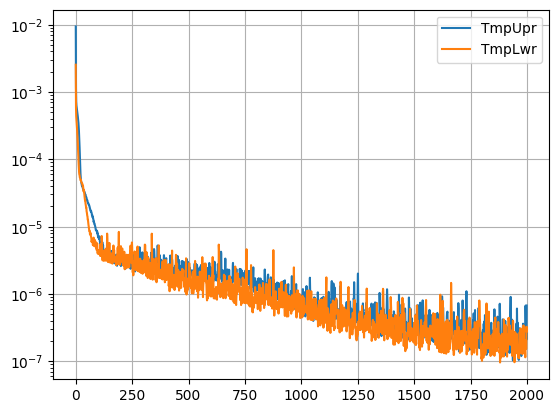

In [17]:
plt.semilogy([i for i in range(len(losses_upr))],losses_upr,label="TmpUpr")
plt.semilogy([i for i in range(len(losses_lwr))],losses_lwr,label="TmpLwr")
plt.grid()
plt.legend()
plt.show()

In [21]:
from steps.compute import compute_differential_inductances_fast
inputs = x.clone().detach().requires_grad_(True)
psi_pred_upr = model_upr(inputs)
L = compute_differential_inductances_fast(psi_pred_upr,inputs,scaler)
psi_pred_lwr = model_lwr(inputs)


In [22]:
def unflatten_table(flat_table, id_vec, iq_vec):
    # Get unique id and iq values
    id = torch.unique(id_vec)
    iq = torch.unique(iq_vec)
    
    # Initialize the table with the correct dimensions
    len_id = len(id)
    len_iq = len(iq)
    table = torch.zeros((len_id, len_iq))
    
    # Fill the table with values from the flat_table
    index = 0
    for iq_counter in range(len_iq):
        for id_counter in range(len_id):
            table[id_counter, iq_counter] = flat_table[index]
            index += 1
    
    return table
psi_pred_upr = psi_pred_upr.clone().detach()
psi_pred_lwr = psi_pred_lwr.clone().detach()
id = torch.tensor(data["id"].values)
iq = torch.tensor(data["iq"].values)
ldd = unflatten_table(L[:,0],id,iq)
ldq = unflatten_table(L[:,1],id,iq)
lqd = unflatten_table(L[:,2],id,iq)
lqq = unflatten_table(L[:,3],id,iq)
psid_upr = unflatten_table(psi_pred_upr[:,0],id,iq)
psiq_upr = unflatten_table(psi_pred_upr[:,1],id,iq)
psid_lwr = unflatten_table(psi_pred_lwr[:,0],id,iq)
psiq_lwr = unflatten_table(psi_pred_lwr[:,1],id,iq)

In [26]:
import scipy.io
data_dict={
    "psid_upr":psid_upr,
    "psiq_upr":psiq_upr,
    "psid_lwr":psid_lwr,
    "psiq_lwr":psiq_lwr,
    "ldd":ldd,
    "ldq":ldq,
    "lqd":lqd,
    "lqq":lqq
}
scipy.io.savemat("../MATLAB/eats2_mopf_L_and_fitted_fluxes.mat",data_dict)


In [25]:
import torch
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.spatial import Delaunay

def log_3d_plot(id:torch.Tensor, iq:torch.Tensor, zs:list, plotnames:list, axislabels:list, title:str, filename:str) -> None:
    """create a 3d plot with the surfaces in zs and save it as html to mlflow
    Args:
        id (torch.Tensor): _description_
        iq (torch.Tensor): _description_
        zs (list): _description_
        plotnames (list): _description_
        axislabels (list): _description_
        title (str): _description_
        filename (str): _description_
    """
    colors =["yellow","blue"]
    fig = go.Figure()
    points2D = np.vstack([id,iq]).T
    tri = Delaunay(points2D)
    for i,z in enumerate(zs):
        fig.add_trace(
            go.Mesh3d(
                x=id, y=iq, z=z,
                i=tri.simplices[:, 0],
                j=tri.simplices[:, 1],
                k=tri.simplices[:, 2],
                name=plotnames[i],
                colorscale=[[0,colors[i]],[1,colors[i]]],
                showlegend=True,
                showscale=False),
        )

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=axislabels[0],
            yaxis_title=axislabels[1],
            zaxis_title=axislabels[2]
        )
    )
    return fig

fig = log_3d_plot(id, iq, [psi_pred_upr[:, 0].detach(), torch.tensor(data["psid_upr"].values)],
            ["psid estimated", "psid true"], ["id [A]", "iq [A]", "PSI [Wb]"], "Psi d", "psid.html")
fig.show()
